# How to implement a neural network Part 3

## Hidden layer trained by backpropagation

This part will illustrate with help of a simple toy example how hidden layers with a [non-linear activation function](http://peterroelants.github.io/posts/neural_network_implementation_part03/#Non-linear-activation-function) can be trained by the [backpropagation](http://peterroelants.github.io/posts/neural_network_implementation_part03/#Optimization-by-backpropagation) algorithm to learn how to seperate non-linearly seperated samples.

While the previous tutorials described very simple single layer regression and classification models, this tutorial will describe a 2-class classification neural network with 1 input dimension, and a non-linear hidden layer with 1 neuron. This network can be represented graphically as:

![Image of the network with hidden layer](/images/neural_net_implementation/SimpleANN03.png)

The notebook starts out with importing the libraries we need:

In [1]:
# Python imports
# Allow matplotlib to plot inside this notebook
%matplotlib inline
import sys
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=4)

# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.6.6
numpy: 1.14.5
matplotlib: 2.2.3
seaborn: 0.9.0


## Define the dataset 

In this example the target classes $t$ corresponding to the inputs $x$ will be generated from 2 class distributions: blue circles ($t=1$) and red stars ($t=0$). Where the red star class is a [multimodal distribution](http://en.wikipedia.org/wiki/Multimodal_distribution) that surrounds the distribution of the blue circle class. This results in a 1D dataset that is not linearly separable. These samples are plotted in the figure below. 

The model from part 2 won't be able to classify both classes correctly since it can learn only linear separations. By adding a hidden layer with a non-linear activation function, the model will be able to train a non-linear classifier.

In [2]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = 0  # The mean of the blue class
red_left_mean = -2  # The mean of the red class
red_right_mean = 2  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
xs_blue = np.random.randn(
    nb_of_samples_per_class, 1) * std_dev + blue_mean
xs_red = np.vstack((
    np.random.randn(  # Red star left samples
        nb_of_samples_per_class//2, 1) * std_dev + red_left_mean,
    np.random.randn(  # Red star right samples
        nb_of_samples_per_class//2, 1) * std_dev + red_right_mean
))

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((xs_blue, xs_red))
t = np.vstack((np.ones((xs_blue.shape[0], 1)), 
               np.zeros((xs_red.shape[0], 1))))
#

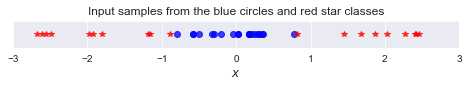

In [3]:
# Plot samples from both classes
plt.figure(figsize=(8, 0.5))
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples
plt.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
plt.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue circles and red star classes')
plt.xlabel('$x$', fontsize=12)
plt.show()
#

## Non-linear activation function 

The non-linear [activation function](https://en.wikipedia.org/wiki/Activation_function) used in the hidden layer of this example is the [Gaussian](http://en.wikipedia.org/wiki/Gaussian_function) [radial basis function](http://en.wikipedia.org/wiki/Radial_basis_function) (RBF). The RBF is a activation function that is not usually used in neural networks, except for [radial basis function networks](http://en.wikipedia.org/wiki/Radial_basis_function_network). It's being used in this example because it's non-linearity allows us to seperate the blue circle class surrounded by the red star class i our toy example.
The RBF will allow to separate the blue circle samples from the red star samples in this simple example by only activating for a certain region around the origin. The RBF is plotted in the figure below and is defined in this example as:

$$ \text{RBF} = \phi(z_h) = e^{-z_h^2} $$

The derivative of this RBF function is:

$$ \frac{d \phi(z_h)}{dz_h} = -2 z_h e^{-z_h^2} = -2 z_h \phi(z_h)$$

In [4]:
def rbf(zh):
    """RBF activation function"""
    return np.exp(-zh**2)

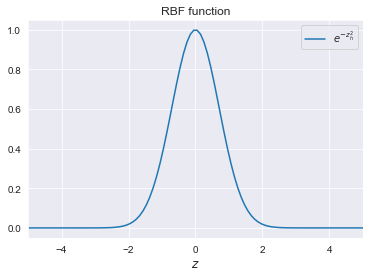

In [5]:
# Plot the rbf function
zhs = np.linspace(-5, 5, 100)
plt.plot(zhs, rbf(zhs), label='$e^{-z_h^2}$')
plt.xlabel('$z$', fontsize=12)
plt.title('RBF function')
plt.legend()
plt.xlim(-5, 5)
plt.show()
#

## Optimization by backpropagation

We will train this model by using the [backpropagation](http://en.wikipedia.org/wiki/Backpropagation) algorithm that is typically used to train neural networks. Each iteration of the backpropagation algorithm consists of two steps:

1. A forward propagation step to compute the output of the network.
2. A backward propagation step in which the error at the end of the network is propagated backward through all the neurons while updating their parameters.

### 1. Forward step

During the forward step, the input will be propagated layer by layer through the network to compute the final output of the network.

#### Compute activations of hidden layer

The activations $\mathbf{h}$ of the hidden layer will be computed by:

$$\mathbf{h} = \text{RBF}(\mathbf{x} \cdot w_h) = e^{-(\mathbf{x} \cdot w_h)^2} $$

With $w_h$ the weight parameter that transforms the input before applying the RBF activation function. This is implemented below by the `hidden_activations(x, wh)` method.

#### Compute activations of output 

The final output of the network will be computed by passing the hidden activations $\mathbf{h}$ as input to the [logistic classifier]({% post_url 2015-06-10-cross_entropy_logistic %}) function $\sigma$:

$$ \mathbf{y} = \sigma(\mathbf{h} + b_o) = \frac{1}{1+e^{-(\mathbf{h}+ b_o)}} $$

With $b_o$ the bias parameter of the output layer. This is implemented below as the `output_activations(h , bo)` method.
Note that in this toy example we don't multiply with a weight parameter and we add a only add a bias (intercept) term to the input of the logistic output neuron.

In [6]:
def logistic(zo):
    """Logistic classifiction function"""
    return 1. / (1. + np.exp(-zo))


def hidden_activations(x, wh):
    """Hidden layer activations from RBF."""
    return rbf(x * wh)


def output_activations(h , bo):
    """Logistic classification output."""
    return logistic(h + bo)


def nn(x, wh, bo):
    """Full neural network function."""
    return output_activations(hidden_activations(x, wh), bo)


def nn_predict(x, wh, bo):
    """Neural network prediction function that only returns
    1 or 0 depending on the predicted class."""
    return np.around(nn(x, wh, bo))

### 2. Backward step

The backward step will begin with computing the loss (error) at the output node. The gradient of this loss will then be propagated backwards layer by layer through the network to calculate the parameter updates. Once we have the gradients for each parameter we can use the [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm to update these parameters.


#### Compute the loss function

The loss function $\xi$ used in this model is the same cross-entropy loss function introduced in [part 2]({% post_url 2015-06-10-neural_network_implementation_part02 %}):

$$\xi(t_i,y_i) = - \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$$

This loss function is plotted for the $w_h$ and $b_o$ parameters in the next figure. Note that this error surface is not convex anymore because we introduced a hidden layer with a non-linearity.

In [7]:
def loss(y, t):
    """Cross entropy loss function."""
    return -np.mean(
        (t * np.log(y)) + ((1-t) * np.log(1-y)))

 
def loss_for_param(x, wh, bo, t):
    """Calculate the loss for a given set of parameters."""
    return loss(nn(x, wh, bo) , t)

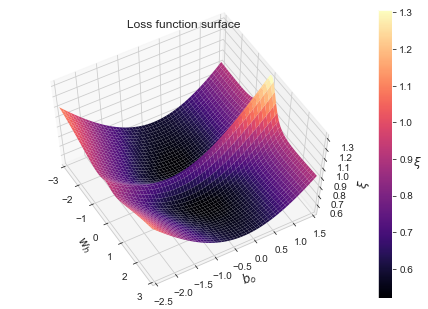

In [8]:
# Plot the loss in function of the weights
# Define a vector of weights for which we want to plot the loss
grid_size = 200 # Grid used to plot loss surface
wsh = np.linspace(-3, 3, num=grid_size) # hidden weights
bso = np.linspace(-2.5, 1.5, num=grid_size) # output weights
params_x, params_y = np.meshgrid(wsh, bso) # generate grid
# Initialise loss surface grid
loss_grid = np.zeros((grid_size, grid_size))
# Fill the loss matrix for each combination of weights
for i in range(grid_size):
    for j in range(grid_size):
        loss_grid[i,j] = loss(
            nn(x, params_x[i,j], params_y[i,j]) , t)
# Plot the loss function surface
fig = plt.figure()
with sns.axes_style("whitegrid"):
    ax = Axes3D(fig)
# plot the surface
surf = ax.plot_surface(
    params_x, params_y, loss_grid, linewidth=0, cmap=cm.magma)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
ax.set_xlabel('$w_h$', fontsize=12)
ax.set_ylabel('$b_o$', fontsize=12)
ax.set_zlabel('$\\xi$', fontsize=12)
ax.set_ylim(-2.5, 1.5)
ax.set_xlim(-3, 3)
cbar.ax.set_ylabel('$\\xi$', fontsize=12, rotation=0)
plt.title('Loss function surface')
plt.show()
#

#### Update the output layer

At the output the gradient for sample $i$, the update ${\partial \xi_i}/{\partial b_o}$ for parameter $b_o$ can be worked out using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) the same way as we did in [part 2]({% post_url 2015-06-10-neural_network_implementation_part02 %}):

$$
\frac{\partial \xi_i}{\partial b_o} 
= \frac{\partial \xi_i}{\partial y_i} \frac{\partial y_i}{\partial z_{oi}} \frac{\partial z_{oi}}{\partial b_o} 
= (y_i-t_i) = \delta_{oi}
$$

With $z_{oi} = h_i + b_o$, $h_i$ the hidden layer activation of sample $i$ and ${\partial \xi_i}/{\partial z_{oi}} = \delta_{oi}$ the gradient of the error at the output layer of the neural network with respect to the input to this layer. Note that ${\partial z_{oi}}/{\partial b_o} = 1$.


$\delta_{o}$ is defined below as the `gradient_output(y, t)` method and ${\partial \xi}/{\partial b_o}$ as the `gradient_bias_out(h, grad_output)` method. Note that these return the same in this case.

#### Update the hidden layer

Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) at the hidden layer parameter $w_h$ we can compute the gradient for sample $i$: ${\partial \xi_i}/{\partial w_{h}}$ the same way:

$$
\frac{\partial \xi_i}{\partial w_{h}} 
= \frac{\partial \xi_i}{\partial h_i} \frac{\partial h_i}{\partial z_{hi}}  \frac{\partial z_{hi}}{\partial w_{h}}
= x_i \cdot \delta_{hi}
$$

With $z_{hi} = x_i \cdot w_{h} $. And with ${\partial \xi_i}/{\partial z_{hi}} = \delta_{hi}$ the gradient of the error at the input of the hidden layer with respect to the input to this layer. $\delta_{hi}$ can be interpreted as the gradient of the contribution of $z_{hi}$ to the final error.

How do we define this error gradient $\delta_{hi}$ at the input of the hidden neurons? It can be computed as the error gradient propagated back from the output layer through the hidden layer.

$$
\begin{split}
\delta_{hi} 
= \frac{\partial \xi_i}{\partial z_{hi}} 
&= \frac{\partial \xi_i}{\partial z_{oi}} \frac{\partial z_{oi}}{\partial h_i} \frac{\partial h_i}{\partial z_{hi}} 
= (-2 \cdot z_{hi} \cdot h_i) \cdot (y_i - t_i) \\
&= -2 \cdot z_{hi} \cdot h_i \cdot \delta_{oi}
\end{split}
$$

Because of this, and because ${\partial z_{hi}}/{\partial w_{h}} = x_i$ we can compute ${\partial \xi_i}/{\partial w_{h}}$ as:

$$\frac{\partial \xi_i}{\partial w_{h}} = x_i \delta_{hi}  $$

The gradients for each parameter can again be averaged of the inputs $i$ to compute the update for a batch of input examples.

$\delta_{h}$ is defined below as the `gradient_hidden(bo, grad_output)` method and ${\partial \xi}/{\partial w_h}$ as the `gradient_weight_hidden(x, zh, h, grad_hidden)` method.

In [9]:
def gradient_output(y, t):
    """Gradient of loss output."""
    return y - t


def gradient_bias_out(grad_output): 
    """Gradient off the bias parameter at the output layer."""
    return grad_output


def gradient_hidden(grad_output):
    """Gradient of hidden layer output."""
    return grad_output


def gradient_weight_hidden(x, zh, h, grad_hidden):
    """Gradient of hidden layer weight parameter wh."""
    return x * -2 * zh * h * grad_hidden

### Backpropagation updates

Once we know how to compute gradient of the loss with respect to the parameters we can start using the [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm to train the network. Gradient descent will iteratively update the parameters in the direction of the negative [gradient](http://en.wikipedia.org/wiki/Gradient). The parameters $w_h$ and $b_o$ are updated scaled by the learning rate $\mu$:

$$
w_h(k+1) = w_h(k) - \Delta w_h(k+1) \quad \text{with} \; \Delta w_h = \mu \cdot {\partial \xi}/{\partial w_h}\\
b_o(k+1) = b_o(k) - \Delta b_o(k+1) \quad \text{with} \; \Delta b_o = \mu \cdot {\partial \xi}/{\partial b_o}
$$

The gradient descent algorithm is typically initialised by starting with random initial parameters. After initiating these parameters we can start updating these parameters with $\Delta$ until convergence. The learning rate needs to be tuned separately as a hyperparameter for each neural network. One backpropagation iteration with gradient descent is implemented below by the `backprop_update(x, t, wh, bo, learning_rate)` method.

I hope that this long writeout of how to update the parameters illustrates that the backpropagation algorithm is just an application of the chain rule for computing derivatives and can be written out for more complex networks if needed.

In [10]:
def backprop_update(x, t, wh, bo, learning_rate):
    """Full backpropagation update function.
    Updates the parameters bo and wh in 1 iteration."""
    # Compute the output of the network
    # This can be done with y = nn(x, wh, bo), but we need
    #  the intermediate h and zh for the weight updates.
    zh = x * wh
    h = rbf(zh)  # h = hidden_activations(x, wh)
    y = output_activations(h, bo)
    # Compute the gradient at the output
    grad_output = gradient_output(y, t)
    # Get the delta for bo
    d_bo = learning_rate * gradient_bias_out(grad_output)
    # Compute the gradient at the hidden layer
    grad_hidden = gradient_hidden(grad_output)
    # Get the delta for wh
    d_wh = learning_rate * gradient_weight_hidden(
        x, zh, h, grad_hidden)
    # return the update parameters
    return float(np.mean(wh-d_wh)), float(np.mean(bo-d_bo))

An example run of backpropagation for 50 iterations on the example inputs $\mathbf{x}$ and targets $\mathbf{t}$ is shown in the figure below. The white dots represent the weight parameter values $w_h$ and $b_o$ at iteration $k$ and are plotted on the loss surface.

In [11]:
# Run backpropagation
# Set the initial weight parameter
wh = 2.3  # Randomly decided
bo = 1.4  # Randomly decided
# Set the learning rate
learning_rate = 2.0

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 20  # number of gradient descent updates
# List to store the weight values for later vizualization
params_loss = [(wh, bo, loss_for_param(x, wh, bo, t))]
for i in range(nb_of_iterations):
    # Update the weights via backpropagation
    wh, bo = backprop_update(x, t, wh, bo, learning_rate)
    # Store the values for plotting
    params_loss.append((wh, bo, loss_for_param(x, wh, bo, t)))

# Print the final loss
final_loss = loss_for_param(x, wh, bo, t)
print(f'final loss is {final_loss:.2f} for weights',
      f'wh={wh:.2f} and bo={bo:.2f}')

final loss is 0.52 for weights wh=1.12 and bo=-0.44


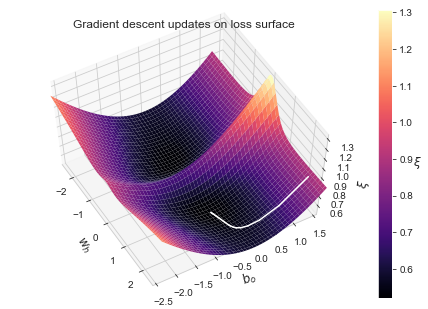

In [12]:
# Plot the weight updates on the error surface
# Plot the error surface
fig = plt.figure()
with sns.axes_style("whitegrid"):
    ax = Axes3D(fig)
surf = ax.plot_surface(
    params_x, params_y, loss_grid, linewidth=0, cmap=cm.magma)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$\\xi$', fontsize=12, rotation=0)

# Plot the updates
for i in range(1, len(params_loss)):
    wh1, bo1, l1 = params_loss[i-1]
    wh2, bo2, l2 = params_loss[i]
    # Plot the update 
    ax.plot([wh1, wh2], [bo1, bo2], [l1, l2], 'w-')
# Show figure
ax.set_xlabel('$w_h$', fontsize=12)
ax.set_ylabel('$b_o$', fontsize=12)
ax.set_zlabel('$\\xi$', fontsize=12)
ax.set_ylim(-2.5, 1.5)
ax.set_xlim(-2.5, 2.5)
plt.title('Gradient descent updates on loss surface')
plt.show()
#

## Visualization of the trained classifier


The resulting decision boundary of running backpropagation on the example inputs $\mathbf{x}$ and targets $\mathbf{t}$ is shown in the figure below. The background color (blue, red) refers to the classification decision between blue circle and red star of the trained classifier at that position in the input space. Note that all examples are classified correctly by the trained classifier.

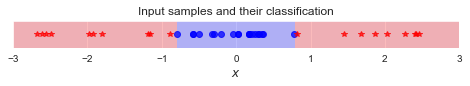

In [13]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs = np.linspace(-3, 3, num=nb_of_xs)
ys = np.linspace(-1, 1, num=nb_of_xs)
xx, yy = np.meshgrid(xs, ys) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_predict(xx[i,j], wh, bo)
# Color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.25),
        colorConverter.to_rgba('b', alpha=0.25)])

# Classification plane with decision boundary and input samples
plt.figure(figsize=(8, 0.5))
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.xlim(-3, 3)
plt.ylim(-1, 1)
# Plot samples from both classes as lines on a 1D space
plt.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
plt.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples and their classification')
plt.xlabel('$x$', fontsize=12)
plt.show()
#

## Transformation of the input domain

How is the neural network able to separate the non-linearly seperable classes with a linear logistic classifier at the output?  The key is the hidden layer with the non-linear RBF activation function. Note that the RBF activation function is able to transform the samples near the origin (blue circle) to a value larger than $0$, and the samples further from the origin (red stars) to a value near $0$. This projection is plotted in the following figure. The horizontal axis has the input $x$ while the vertical axis shows the transformed input $h = RBF(x \cdot w_h)$.

Note that in the vertical axis $h$ the red stars are located closer to $0$, and that the blue circles are located more to $1$. This projection is linearly seperable by the logistic classifier in the output layer.

Also, note that the offset of the peak of the Gaussian function we use is $0$. This means that the Gaussian function is centered around the origin, which can be noted in the symmetrical decision boundaries around the origin on the previous figure.

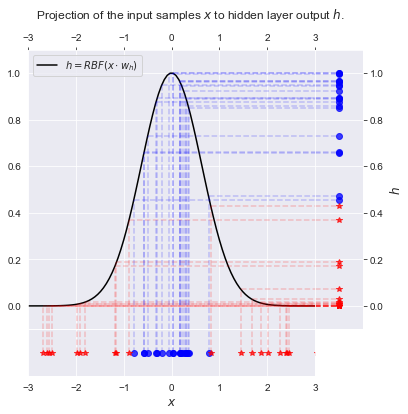

In [14]:
# Illustrate the transformation of x to h
plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[6, 1], height_ratios=[6, 1])
gs.update(wspace=0., hspace=0.)
plt.suptitle((
    'Projection of the input samples $x$ '
    'to hidden layer output $h$.'))

# Plot input
ax_in = plt.subplot(gs[2])
ax_in.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
ax_in.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
ax_in.yaxis.set_visible(False)
ax_in.set_xlabel('$x$', fontsize=12)
ax_in.set_xlim(-3,3)
ax_in.set_ylim(-1,1)
# Plot red star projections
for xr in xs_red:
    ax_in.plot((xr, xr), (0, 1), 'r--', alpha=0.2)
# Plot blue circle projections
for xb in xs_blue:
    ax_in.plot((xb, xb), (0, 2), 'b--', alpha=0.2)

# Plot RBF function
ax_rbf = plt.subplot(gs[0])
xs_rbf = np.linspace(-3, 3, 100)
ax_rbf.plot(
    xs_rbf, hidden_activations(xs_rbf, wh), 
    'k-', label='$h = RBF(x \cdot w_h)$')
ax_rbf.legend()
ax_rbf.set_xlim(-3, 3)
ax_rbf.set_ylim(-0.1, 1.1)
ax_rbf.xaxis.set_ticks_position('top')
# Plot red star projections
for xr in xs_red:
    h = hidden_activations(xr, wh)
    ax_rbf.plot((xr, xr), (-0.1, h), 'r--', alpha=0.2)
    ax_rbf.plot((xr, 3), [h, h], 'r--', alpha=0.2)
# Plot blue circle projections
for xb in xs_blue:
    h = hidden_activations(xb, wh)
    ax_rbf.plot((xb, xb), (-0.1, h), 'b--', alpha=0.2)
    ax_rbf.plot((xb, 3), [h, h], 'b--', alpha=0.2)

# Plot output
ax_out = plt.subplot(gs[1])
ax_out.plot(
    np.zeros_like(xs_blue), hidden_activations(xs_blue, wh), 
    'bo', alpha=0.75)
ax_out.plot(
    np.zeros_like(xs_red), hidden_activations(xs_red, wh), 
    'r*', alpha=0.75)
ax_out.xaxis.set_visible(False)
ax_out.yaxis.set_label_position('right')
ax_out.yaxis.set_ticks_position('right')
ax_out.set_ylabel('$h$', fontsize=12)
ax_out.set_ylim(-0.1, 1.1)
ax_out.set_xlim(-1, 1)
# Plot red star projections
for xr in xs_red:
    h = hidden_activations(xr, wh)
    ax_out.plot((-1, 0), (h, h), 'r--', alpha=0.2)
# Plot blue circle projections
for xb, in xs_blue:
    h = hidden_activations(xb, wh)
    ax_out.plot((-1, 0), (h, h), 'b--', alpha=0.2)

plt.show()
#

This post at [peterroelants.github.io](http://peterroelants.github.io/) is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part03.ipynb)